
Raw data preview:
          c        T_PM       d50       d90       d10        T_TM     mf_PM  \
0  0.176778  318.716784  0.000293  0.000355  0.000279  318.577217  0.000665   
1  0.176777  318.716784  0.000331  0.000400  0.000256  318.577217  0.000665   
2  0.176776  318.716784  0.000314  0.000357  0.000188  318.577217  0.000665   
3  0.176775  318.716784  0.000260  0.000304  0.000248  318.577217  0.000665   
4  0.176778  318.716784  0.000333  0.000372  0.000315  318.577217  0.000665   

     mf_TM           Q_g  w_crystal     c_in     T_PM_in     T_TM_in  \
0  0.01628  6.437788e-07   0.003225  0.17695  323.120637  323.120637   
1  0.01628  6.437788e-07   0.003225  0.17695  323.120637  323.120637   
2  0.01628  6.437788e-07   0.003225  0.17695  323.120637  323.120637   
3  0.01628  6.437788e-07   0.003225  0.17695  323.120637  323.120637   
4  0.01628  6.437788e-07   0.003225  0.17695  323.120637  323.120637   

       source  
0  file_14894  
1  file_14894  
2  file_14894  
3  file_1

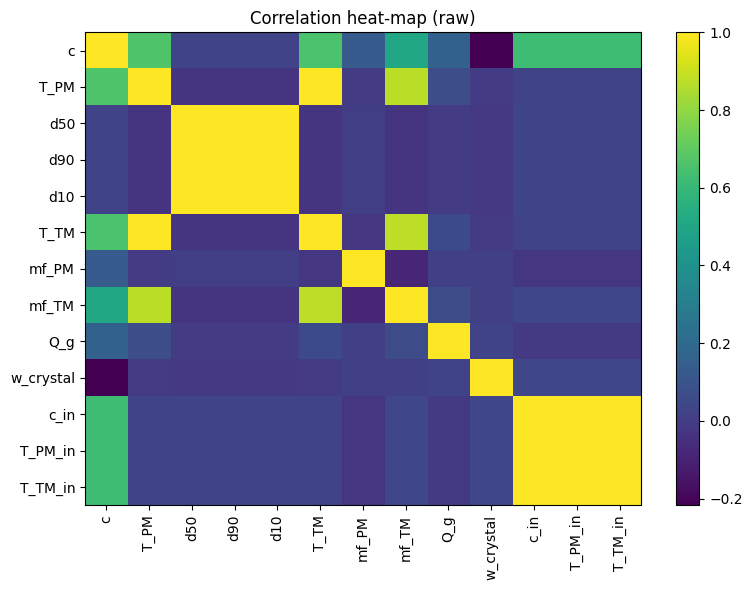

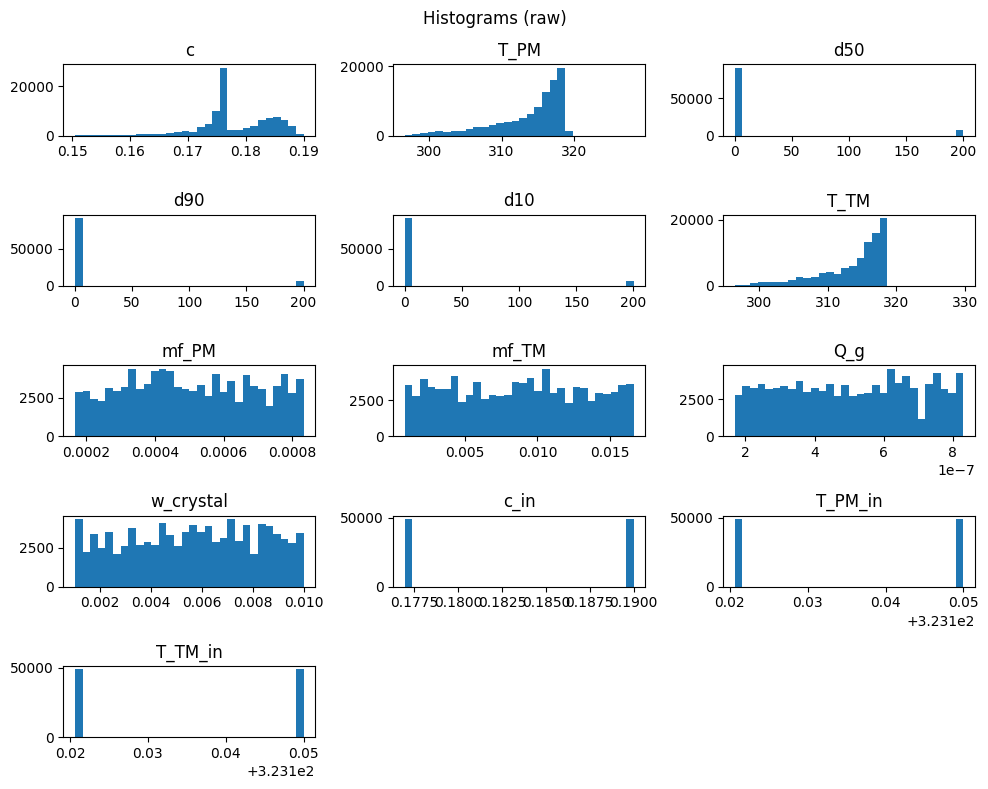

Dropped 3 highly correlated feature(s): ['T_TM', 'T_PM_in', 'T_TM_in']

Cleaned data preview:
          c        T_PM     mf_PM    mf_TM           Q_g  w_crystal     c_in  \
0  0.176778  318.716784  0.000665  0.01628  6.437788e-07   0.003225  0.17695   
1  0.176777  318.716784  0.000665  0.01628  6.437788e-07   0.003225  0.17695   
2  0.176776  318.716784  0.000665  0.01628  6.437788e-07   0.003225  0.17695   
3  0.176775  318.716784  0.000665  0.01628  6.437788e-07   0.003225  0.17695   
4  0.176778  318.716784  0.000665  0.01628  6.437788e-07   0.003225  0.17695   

       source    spread      skew  
0  file_14894  0.000076  0.235608  
1  file_14894  0.000144  1.077887  
2  file_14894  0.000169  2.928088  
3  file_14894  0.000055  0.260064  
4  file_14894  0.000057  0.439358  


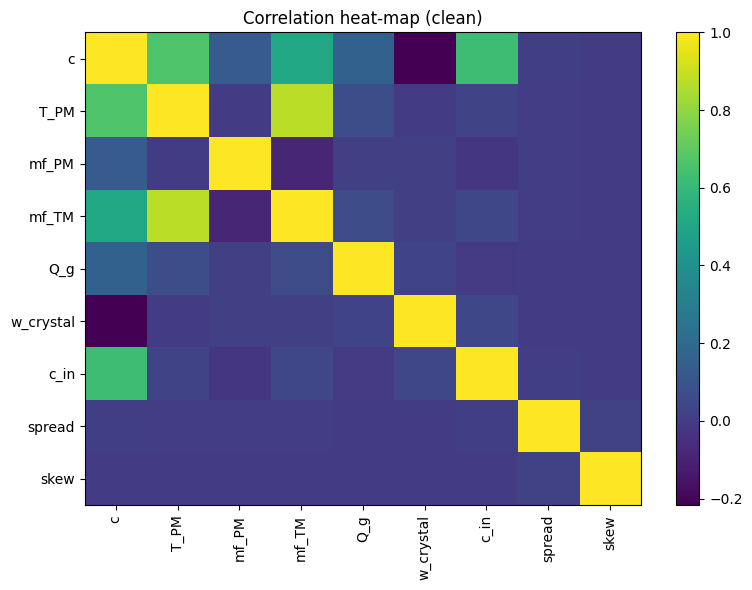

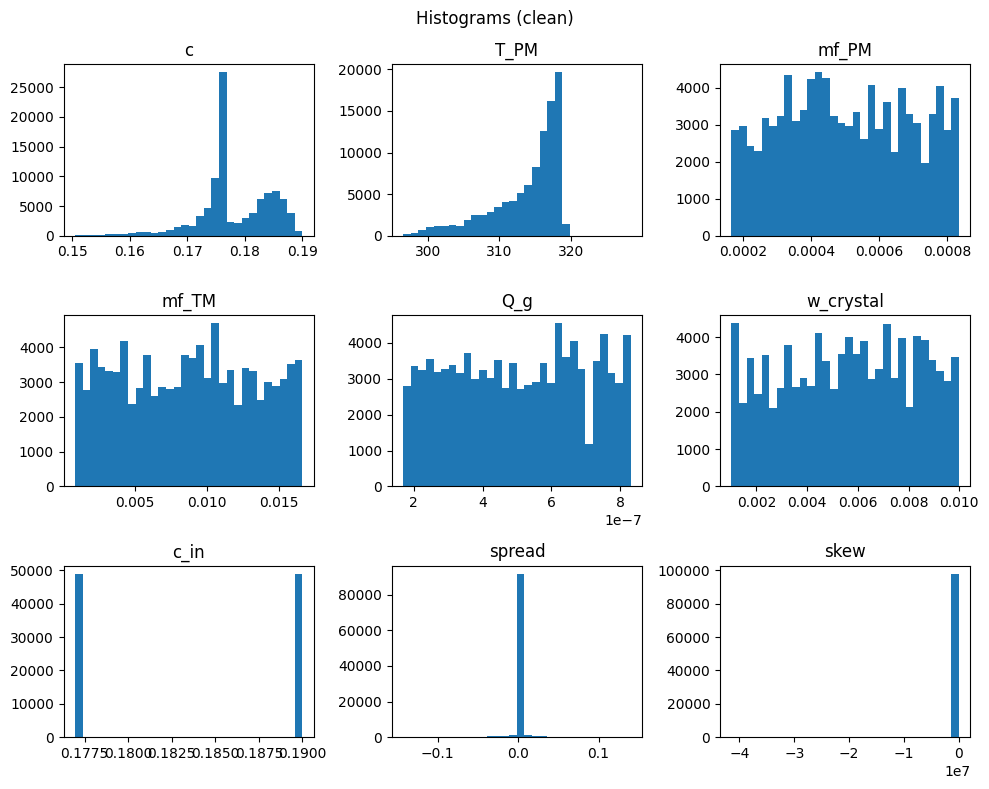


Workflow:
  • Loads all text files in data_dir
  • Visualises *raw* data (heat-map + histograms)
  • Engineers spread & skew, drops high-corr features
  • Visualises *clean* data

Adjust paths, separators, or the correlation threshold as needed.


In [2]:
"""
main.py — load, tidy and visualise data
---------------------------------------
Now shows plots *before* and *after* preprocessing.
"""

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import load_txt_folder           # your existing loader
# ────────────────────────────────────────────────────────────────
# Feature-engineering / de-correlation helper (unchanged)
# ────────────────────────────────────────────────────────────────
def tidy_features(
    df: pd.DataFrame,
    *,
    corr_thresh: float = 0.95,
    eps: float = 1e-9,
    spread_name: str = "spread",
    skew_name: str = "skew",
) -> pd.DataFrame:
    df = df.copy()

    # combine d10/d50/d90 → spread & skew
    if {"d10", "d50", "d90"}.issubset(df.columns):
        d10, d50, d90 = df["d10"], df["d50"], df["d90"]
        df[spread_name] = d90 - d10
        df[skew_name]   = (d50 - d10) / (d90 - d50 + eps)
        df.drop(columns=["d10", "d50", "d90"], inplace=True)

    # drop highly-correlated numeric cols
    num_df = df.select_dtypes(include="number")
    corr   = num_df.corr().abs()
    upper  = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [c for c in upper.columns if any(upper[c] > corr_thresh)]
    if to_drop:
        df.drop(columns=to_drop, inplace=True)
        print(f"Dropped {len(to_drop)} highly correlated feature(s): {to_drop}")

    return df

# ────────────────────────────────────────────────────────────────
# Visualisation helpers  (add optional label)
# ────────────────────────────────────────────────────────────────
def _heatmap(df: pd.DataFrame, *, figsize=(8, 6), label: str = "") -> None:
    corr = df.corr(numeric_only=True)
    if corr.empty:
        print("No numeric data to plot a heat-map.")
        return

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(corr, aspect="auto")
    ax.set_xticks(np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
    ax.set_yticks(np.arange(len(corr.columns)), labels=corr.columns)
    ax.set_title(f"Correlation heat-map {label}")
    fig.colorbar(im, ax=ax)
    fig.tight_layout()


def _histograms(
    df: pd.DataFrame,
    *,
    bins: int = 30,
    ncols: int = 3,
    figsize=(10, 8),
    label: str = "",
) -> None:
    num_df = df.select_dtypes(include="number")
    if num_df.empty:
        print("No numeric columns for histograms.")
        return

    nrows = -(-num_df.shape[1] // ncols)  # ceiling division
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    axes = axes.flatten()

    for i, col in enumerate(num_df.columns):
        axes[i].hist(num_df[col].dropna(), bins=bins)
        axes[i].set_title(col)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(f"Histograms {label}")
    fig.tight_layout()


def visualize(df: pd.DataFrame, *, label: str = "") -> None:
    _heatmap(df, label=label)
    _histograms(df, label=label)
    plt.show()

# ────────────────────────────────────────────────────────────────
# Main entry-point
# ────────────────────────────────────────────────────────────────
def main() -> None:
    data_dir = Path(r"C:\Users\tej31\Documents\GitHub\MLME-ANN\Data")
    df_raw = load_txt_folder(data_dir, sep="\t")        # ↪ raw

    print("\nRaw data preview:")
    print(df_raw.head())

    # ── 1️⃣  Visualise BEFORE preprocessing ─────────────────────────
    visualize(df_raw, label="(raw)")

    # ── 2️⃣  Preprocess, then visualise AFTER ───────────────────────
    df_clean = tidy_features(df_raw, corr_thresh=0.95)

    print("\nCleaned data preview:")
    print(df_clean.head())

    visualize(df_clean, label="(clean)")

if __name__ == "__main__":
    main()

    print(
        "\nWorkflow:\n"
        "  • Loads all text files in data_dir\n"
        "  • Visualises *raw* data (heat-map + histograms)\n"
        "  • Engineers spread & skew, drops high-corr features\n"
        "  • Visualises *clean* data\n"
        "\nAdjust paths, separators, or the correlation threshold as needed."
    )
